<a href="https://colab.research.google.com/github/MyDearGreatTeacher/TF/blob/master/TF_ML_IRIS_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instructions for updating:
Colocations handled automatically by placer.
Calculating gen 0, out of 25.
Group counts: [23, 87, 40]
Calculating gen 1, out of 25.
Group counts: [10, 70, 70]
Calculating gen 2, out of 25.
Group counts: [9, 52, 89]
Calculating gen 3, out of 25.
Group counts: [10, 46, 94]
Calculating gen 4, out of 25.
Group counts: [7, 50, 93]
Calculating gen 5, out of 25.
Group counts: [24, 50, 76]
Calculating gen 6, out of 25.
Group counts: [33, 50, 67]
Calculating gen 7, out of 25.
Group counts: [37, 50, 63]
Calculating gen 8, out of 25.
Group counts: [41, 50, 59]
Calculating gen 9, out of 25.
Group counts: [46, 50, 54]
Calculating gen 10, out of 25.
Group counts: [50, 50, 50]
Calculating gen 11, out of 25.
Group counts: [54, 50, 46]
Calculating gen 12, out of 25.
Group counts: [57, 50, 43]
Calculating gen 13, out of 25.
Group counts: [60, 50, 40]
Calculating gen 14, out of 25.
Group counts: [61, 50, 39]
Calculating gen 15, out of 25.
Group counts: [61, 50, 39]
Calculating 

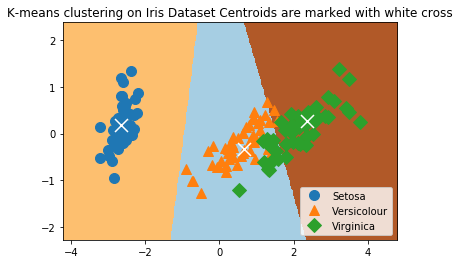

In [1]:
# -*- coding: utf-8 -*-
# K-means with TensorFlow
#----------------------------------
#
# This script shows how to do k-means with TensorFlow

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from tensorflow.python.framework import ops
ops.reset_default_graph()

sess = tf.Session()

iris = datasets.load_iris()

num_pts = len(iris.data)
num_feats = len(iris.data[0])

# Set k-means parameters
# There are 3 types of iris flowers, see if we can predict them
k = 3
generations = 25

data_points = tf.Variable(iris.data)
cluster_labels = tf.Variable(tf.zeros([num_pts], dtype=tf.int64))

# Randomly choose starting points
rand_starts = np.array([iris.data[np.random.choice(len(iris.data))] for _ in range(k)])

centroids = tf.Variable(rand_starts)

# In order to calculate the distance between every data point and every centroid, we
#  repeat the centroids into a (num_points) by k matrix.
centroid_matrix = tf.reshape(tf.tile(centroids, [num_pts, 1]), [num_pts, k, num_feats])
# Then we reshape the data points into k (3) repeats
point_matrix = tf.reshape(tf.tile(data_points, [1, k]), [num_pts, k, num_feats])
distances = tf.reduce_sum(tf.square(point_matrix - centroid_matrix), axis=2)

# Find the group it belongs to with tf.argmin()
centroid_group = tf.argmin(distances, 1)


# Find the group average
def data_group_avg(group_ids, data):
    # Sum each group
    sum_total = tf.unsorted_segment_sum(data, group_ids, 3)
    # Count each group
    num_total = tf.unsorted_segment_sum(tf.ones_like(data), group_ids, 3)
    # Calculate average
    avg_by_group = sum_total/num_total
    return avg_by_group


means = data_group_avg(centroid_group, data_points)

update = tf.group(centroids.assign(means), cluster_labels.assign(centroid_group))

init = tf.global_variables_initializer()

sess.run(init)

for i in range(generations):
    print('Calculating gen {}, out of {}.'.format(i, generations))
    _, centroid_group_count = sess.run([update, centroid_group])
    group_count = []
    for ix in range(k):
        group_count.append(np.sum(centroid_group_count==ix))
    print('Group counts: {}'.format(group_count))
    

[centers, assignments] = sess.run([centroids, cluster_labels])


# Find which group assignments correspond to which group labels
# First, need a most common element function
def most_common(my_list):
    return max(set(my_list), key=my_list.count)


label0 = most_common(list(assignments[0:50]))
label1 = most_common(list(assignments[50:100]))
label2 = most_common(list(assignments[100:150]))

group0_count = np.sum(assignments[0:50] == label0)
group1_count = np.sum(assignments[50:100] == label1)
group2_count = np.sum(assignments[100:150] == label2)

accuracy = (group0_count + group1_count + group2_count)/150.

print('Accuracy: {:.2}'.format(accuracy))

# Also plot the output
# First use PCA to transform the 4-dimensional data into 2-dimensions
pca_model = PCA(n_components=2)
reduced_data = pca_model.fit_transform(iris.data)
# Transform centers
reduced_centers = pca_model.transform(centers)

# Step size of mesh for plotting
h = .02

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Get k-means classifications for the grid points
xx_pt = list(xx.ravel())
yy_pt = list(yy.ravel())
xy_pts = np.array([[x, y] for x, y in zip(xx_pt, yy_pt)])
mytree = cKDTree(reduced_centers)
dist, indexes = mytree.query(xy_pts)

# Put the result into a color plot
indexes = indexes.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(indexes, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

# Plot each of the true iris data groups
symbols = ['o', '^', 'D']
label_name = ['Setosa', 'Versicolour', 'Virginica']
for i in range(3):
    temp_group = reduced_data[(i*50):(50)*(i+1)]
    plt.plot(temp_group[:, 0], temp_group[:, 1], symbols[i], markersize=10, label=label_name[i])
# Plot the centroids as a white X
plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
plt.title('K-means clustering on Iris Dataset Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='lower right')
plt.show()